<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#General-instructions-for-cython" data-toc-modified-id="General-instructions-for-cython-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General instructions for cython</a></span></li><li><span><a href="#Cython-first-encounters" data-toc-modified-id="Cython-first-encounters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cython first encounters</a></span><ul class="toc-item"><li><span><a href="#fibonnachi" data-toc-modified-id="fibonnachi-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>fibonnachi</a></span><ul class="toc-item"><li><span><a href="#Annotations-in-cython" data-toc-modified-id="Annotations-in-cython-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Annotations in cython</a></span></li></ul></li><li><span><a href="#Finding-divisors-of-an-integer" data-toc-modified-id="Finding-divisors-of-an-integer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Finding divisors of an integer</a></span></li><li><span><a href="#For-loop-counting" data-toc-modified-id="For-loop-counting-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>For loop counting</a></span></li></ul></li></ul></div>

In [12]:
%load_ext cython

In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext cython
%timeit

import Cython
import os
import subprocess
import matplotlib
matplotlib.style.use('ggplot')
import pandas

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


# General instructions for cython

##### distutils

Python standard library includes the `distutils` package for building packaging and distributing python projects. We will use `distutils` for compiling C source into an extension module. We will not directly write C code. We will use `Cython` to generate C code for us. Then the c code will be compiled to an extension module using `distutils.core.setup`.

Let us assume we have written a `Cython` function 'some_function.pyx'. Then the following code is compiles the Cython function to C.

```
from distutils.core import setup
from Cython.Build import cythonize
setup(ext_modules=cythonize('some_function.pyx')
```

We can put the previous code into a file `setup_cy.py` and run in the terminal

```
python setup_cy.py build_ext --inplace
```
Notice that:
- the `build_ext` argument is an standard `distutils` argument to build the `Extension` object (or objects) that the `cythonize` command inside `setup_cy.py` created.


# Cython first encounters

To use cython code inisde a cell use the ``%%cython`` marker to compile it.

This notebook presents the very basics to understand how to speed up python functions using cython.


##  fibonnachi

In [27]:
def fib(n):
    a = 0
    b = 1
    for i in range(n):
        a, b = a + b, a
    return a

In [287]:
fib(10)

55

Now we want to create a cython version of the same function.

Notice we wrote:
    
- `cdef long i`: This is giving a type to variable i (type long or int64)
    
- `cdef long a=`: This is giving a type to variable a and a value.

In [25]:
%%cython
#%%cython -a
def  cy_fib(long n):
    cdef long i
    cdef long a=0, b=1
    for i in range(n):
        a, b = a + b, a
    return a

In [26]:
cy_fib

<function _cython_magic_09288192d194552c392b1456a0d095f5.cy_fib>

In [29]:
cy_fib(10)

55

In [30]:
%%timeit -o
cy_fib(1000)

263 ns ± 1.17 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<TimeitResult : 263 ns ± 1.17 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>

In [31]:
cython_fib_time = _

In [32]:
%%timeit -o
fib(1000)

53.8 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 53.8 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [33]:
python_fib_time = _

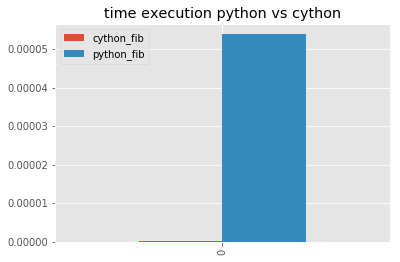

In [37]:
df_time = pandas.DataFrame({"cython_fib":[cython_fib_time.average],
                            "python_fib":[python_fib_time.average]})

df_time.plot(kind='bar', title="time execution python vs cython")

In [42]:
print(cython_fib_time)
print(python_fib_time)

263 ns ± 1.17 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
53.8 µs ± 232 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Annotations in cython

You can show Cython’s code analysis by passing the `--annotate` option:

In [71]:
%%cython --annotate

def cy_fib(long n):
    cdef long i
    cdef long a=0, b=1
    for i in range(n):
        a, b = a + b, a
    return a

In this case we can see that the definition of the method is in yellow and the return is in yellow.

Yellow parts show slow lines of the code.

If we want to make this code faster we need to give a return type to the function, which is written before the name of the function. This means that writting `cdef long namefunc` we specify to the copiler that `namefunc` will return a `long` instance.

In [90]:
%%cython --annotate

cpdef long cy_fib_cdef(long n):
    cdef long i
    cdef long a=0, b=1
    for i in range(n):
        a, b = a + b, a
    return a

In [92]:
%%timeit -o
cy_fib_cdef(1000)

262 ns ± 1.07 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<TimeitResult : 262 ns ± 1.07 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>

In this case we see no performance uplift but it turns out that if we have to call lots of times this method in cython it will be faster.

## Finding divisors of an integer

Let´s make a function to compute all divisors for a given natural number.


In [1]:
import math

def all_divisors(x):
    divisors = []
    for i in range(1,x//2+1):
        if x%i ==0:
            divisors.append(i)
    
    return divisors


In [2]:
%%timeit -o
all_divisors(10000)

262 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 262 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [4]:
timeit_all_divisors = _

Let's now cythonize the function

In [281]:
%%cython -a

def cy_all_divisors(int x):
    cdef int i    
    cdef int n_max = x//2+1
    divisors = []
    for i in range(1,x//2+1):
        if x%i ==0:
            divisors.append(i)
    
    return divisors

Notice there are lots of yellow lines:
    
- 05: Is yellow because we are using a python list
- 07: Is yellow because % is a python operator
- 08: Is yellow because we are using a python mehod
- 10: Is yellow because we have not typed the method

In [121]:
%%timeit -o
cy_all_divisors(10000)

14.2 µs ± 44.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<TimeitResult : 14.2 µs ± 44.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>

In [122]:
timeit_cy_all_divisors = _

In [123]:
timeit_cy_all_divisors

<TimeitResult : 14.2 µs ± 44.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>

In [127]:
timeit_all_divisors

<TimeitResult : 245 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

##### Changing  `X%i` by `cython.cmod`

In cython we have

- `cython.cmod` (for `%`) 
- `cython.cdiv` (for `/`)

We can then call a cython function in our code to get ride of the yellow part in 07

In [285]:
%%cython -a
#@cython.boundscheck(False) 

#@cython.boundscheck(False) 

import cython
cimport numpy as np
import numpy as np

cdef int cy_all_divisors2(int x):
    cdef int i    
    divisors =[]
    cdef int n_max = x//2+1
    
    for i in range(1,n_max):
        if cython.cmod(x,i) ==0:
            divisors.append(i)
    
    return divisors

In [286]:
%%timeit -o
cy_all_divisors2(10000)

10.5 µs ± 69.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<TimeitResult : 10.5 µs ± 69.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>

Now we only need to deal with the list because it's what is causing issues in 12 and 17 in the code above

TODO: MAKE SURE THIS WORKS IN A NOTEBOOK

Now we want to solve 11 and 16 using a datasctructure that does not make calls into python runtime.

%%cython -cplus

from libcpp.vector cimport vector

def cy_all_divisors2(int x):
    cdef int i    
    cdef vector[int] divisors 
    
    for i in range(1,x//2+1):
        if x%i ==0:
            divisors.push_back(i)
    
    return divisors

## For loop counting

In [6]:
import numpy as np

np.random.seed(1234)
vec = np.random.randint(0,5,10000)

In [7]:
def summing(vec):
    total = 0
    for x in vec:
        total+=x
    return total

In [18]:
%%timeit -o
summing(vec)

1.6 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 1.6 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [19]:
time_summing = _

In [21]:
%%cython --annotate

def cy_summing1(long[:] vec):
    
    cdef long total = 0;
    cdef int i;
    cdef int len_vec = len(vec)
    
    for i in range(len_vec):
        total += vec[i]

    return total

In [22]:
%%timeit -o
cy_summing1(vec)

4.47 µs ± 41.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<TimeitResult : 4.47 µs ± 41.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>

In [23]:
timeit_cy_summing1 = _

In [25]:
time_summing

<TimeitResult : 1.6 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [24]:
timeit_cy_summing1

<TimeitResult : 4.47 µs ± 41.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>